<a href="https://colab.research.google.com/github/yuanwxu/corr-net-classify/blob/main/Understanding_MB_interactions_with_Graph_CNN_MBQC_baseline_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use DGCNN algorithm to classify microbial co-abundance networks of CRC and Control - MBQC baseline data

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

     |████████████████████████████████| 440kB 29.5MB/s 
     |████████████████████████████████| 235kB 34.5MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


In [ ]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from sklearn import model_selection

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_graphs2(W, node_features=None):
  """Read graphs into list of StellarGraph instances
     Args:
          W: dataframe of graphs with 4 columns: graph_ind, source, target, weight
  """
  out = list()
  if node_features:
    for _,g in W.groupby('graph_ind'):
      out.append(StellarGraph(nodes=node_features,     
                              edges=g.drop(columns='graph_ind'),
                              node_type_default='microbe',
                              edge_type_default='correlation'))  
  else:
    for _,g in W.groupby('graph_ind'):
      out.append(StellarGraph(edges=g.drop(columns='graph_ind'),
                              node_type_default='microbe',
                              edge_type_default='correlation'))  
  # Check all graphs have the same number of nodes
  nn = [g.number_of_nodes() for g in out]
  if not all(nn[0] == x for x in nn):
      raise ValueError("Not all graphs have same number of nodes, possibly incorrect chunk size.")
  return out

## Build and train graph classification model

In [ ]:
def train_dgcnn(graphs, graph_labels, n_epochs=50):
  """ Build and train DGCNN model for input graphs """
  generator = PaddedGraphGenerator(graphs=graphs)
  k = graphs[0].number_of_nodes()  # the number of rows for the output tensor, no truncation
                                 # done here because all graphs have same number of nodes
  layer_sizes = [32, 32, 32, 1]

  dgcnn_model = DeepGraphCNN(
      layer_sizes=layer_sizes,
      activations=["tanh", "tanh", "tanh", "tanh"],
      k=k,
      bias=False,
      generator=generator,
  )
  x_inp, x_out = dgcnn_model.in_out_tensors()
  x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
  x_out = MaxPool1D(pool_size=2)(x_out)
  x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
  x_out = Flatten()(x_out)
  x_out = Dense(units=128, activation="relu")(x_out)
  x_out = Dropout(rate=0.5)(x_out)
  predictions = Dense(units=1, activation="sigmoid")(x_out)
  model = Model(inputs=x_inp, outputs=predictions)
  model.compile(
      optimizer=Adam(learning_rate=0.0001), loss=binary_crossentropy, metrics=["acc"],
  )

  train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.8, test_size=None, stratify=graph_labels
  )

  gen = PaddedGraphGenerator(graphs=graphs)

  # if use symmetric normalization, problem arise in negative degree values (because 
  # graph can have negative weights), and so can't take square root of those.
  train_gen = gen.flow(
      list(train_graphs.index),
      targets=train_graphs.values,
      batch_size=20,
      symmetric_normalization=False, 
      weighted=True,
  )

  test_gen = gen.flow(
      list(test_graphs.index),
      targets=test_graphs.values,
      batch_size=1,
      symmetric_normalization=False,
      weighted=True,
  )

  history = model.fit(
    train_gen, epochs=n_epochs, verbose=0, validation_data=test_gen, shuffle=True
  )
  # Print test set metrics
  test_metrics = model.evaluate(test_gen, verbose=0)
  print(f'Test Set Metrics: ')
  for name, val in zip(model.metrics_names, test_metrics):
      print("\t{}: {:0.4f}".format(name, val))
  
  return model, history

## Node/Edge importance

In [ ]:
class ImportanceDGCNN:  

  def __init__(self, W, node_features, model):
    """Initialize object for computing node/edge importance in predicting positive/negative class
       resulting from the DGCNN graph classification model
       Args:
            W: dataframe of graphs with 4 columns: graph_ind, source, target, weight
            node_features: used to build StellarGraph graph instance, same as read_graphs
            model: the trained keras model of DGCNN
    """
    self._W = W
    self._node_features = node_features

    # Check if all graphs have same number of edges
    gsize = W.groupby('graph_ind').size() 
    if not all(x == gsize.iat[0] for x in gsize):
      raise ValueError("Not all graphs have the same set of edges. This case is not implemented.")

    # Take any graph from W to find its edges
    gid = W.iloc[0].at['graph_ind']
    W1 = W[W['graph_ind'] == gid]
    self.edges = list(zip(W1['source'], W1['target']))
    self.nodes = node_features.index
    self.ngraphs = W.groupby('graph_ind').ngroups
    self.model = model

  def _null_edge_graphs(self, val=0):
    """ Generator of StellarGraph graphs with exactly one edge set to 'val' (default 0)
    """
    for src, tar in self.edges:
      cond = (self._W['source'] == src) & (self._W['target'] == tar)
      W2 = self._W.copy()
      W2['weight'].mask(cond, val, inplace=True) # set weights corresonding to edge to 0
      for _, g in W2.groupby('graph_ind'):
        yield StellarGraph(nodes=self._node_features, edges=g.drop(columns='graph_ind'),
                           node_type_default='microbe', edge_type_default='correlation')


  def _null_node_graphs(self):
    """ Generator of StellarGraph graphs with all edges incident to a node set to 0
    """
    for n in self.nodes:
      cond = (self._W['source'] == n) | (self._W['target'] == n)
      W2 = self._W.copy()
      W2['weight'].mask(cond, 0, inplace=True)
      for _, g in W2.groupby('graph_ind'):
        yield StellarGraph(nodes=self._node_features, edges=g.drop(columns='graph_ind'),
                           node_type_default='microbe', edge_type_default='correlation')
        
        
  def _null_2nodes_graphs(self):
    """Generator of StellarGraph graphs with all edges incident to two nodes set to 0
    """
    for n1, n2 in self.edges:
      cond1 = (self._W['source'] == n1) | (self._W['target'] == n1)
      cond2 = (self._W['source'] == n2) | (self._W['target'] == n2)
      W2 = self._W.copy()
      W2['weight'].mask(cond1 | cond2, 0, inplace=True)
      for _, g in W2.groupby('graph_ind'):
        yield StellarGraph(nodes=self._node_features, edges=g.drop(columns='graph_ind'),
                           node_type_default='microbe', edge_type_default='correlation')
        
  def _null_nnodes_graphs(self, nlist):
    """ Generator of StellarGraph graphs with all edges incident to n nodes set to 0,
        Assume the first n-1 nodes are given so only the n'th node need chosen
    """
    from functools import reduce
    import operator

    if not set(nlist).issubset(self.nodes):
      raise ValueError("Not all provided nodes are found in the graph")

    conds = [(self._W['source'] == nd) | (self._W['target'] == nd) for nd in nlist]
    for n in self.nodes:
      if n in nlist:
        continue
      combined_cond = conds + [(self._W['source'] == n) | (self._W['target'] == n)]
      reduced_cond = reduce(operator.or_, combined_cond)
      W2 = self._W.copy()
      W2['weight'].mask(reduced_cond, 0, inplace=True)
      for _, g in W2.groupby('graph_ind'):
        yield StellarGraph(nodes=self._node_features, edges=g.drop(columns='graph_ind'),
                           node_type_default='microbe', edge_type_default='correlation')
    
        

  @staticmethod
  def _batch(iterable, n):
    """ Generate prediction batch of size n, using the grouper idiom """
    iters = [iter(iterable)] * n
    return zip(*iters)

  @staticmethod
  def compute_lor(pred, P_new):
    """ Compute log-odds ratio between new and original graph predicted probs 
        Args:
            pred: prediction on the original graphs, output of model.predict(),
                  shape N-by-1, where N number of graph instances
            P_new: predicition on new graphs, shape N-by-K, where K = number of
                   edges/nodes depending on edge or node importance 
        Returns:
            numpy array same shape as P_new
    """
    eps = 1e-6
    lo1 = np.log(P_new+eps) - np.log(1-P_new+eps)
    lo2 = np.log(pred+eps) - np.log(1-pred+eps)
    return lo1 - lo2

  def read_sg(self):
    """ Read graphs into list of StellarGraph instances """
    out = list()
    for _,g in self._W.groupby('graph_ind'):
      out.append(StellarGraph(nodes=self._node_features,     
                              edges=g.drop(columns='graph_ind'),
                              node_type_default='microbe',
                              edge_type_default='correlation')) 
    return out 

  def predict_graph(self, graphs):
    """Use the model to predict the probability of positive class
       Args:
          graphs: list of StellarGraph graph instances
    """
    fl = PaddedGraphGenerator(graphs=graphs).flow(range(len(graphs)), 
                                                  batch_size=len(graphs), 
                                                  symmetric_normalization=False, 
                                                  weighted=True)
    return self.model.predict(fl)

  def edge_imp(self, set_wt=0):
    """Calclate edge importance by log-odds ratio of the probability of the class 
       when an edge weight is set to 'set_wt' (default 0), to that of the original graph instance
    """
    sg = self.read_sg()
    pred = self.predict_graph(sg)
    P_new = np.empty((self.ngraphs, len(self.edges)))
    
    gen = self._null_edge_graphs(set_wt)
    for i, bch in enumerate(ImportanceDGCNN._batch(gen, self.ngraphs)):
      pred_new = self.predict_graph(list(bch)).reshape(-1)
      P_new[:,i] = pred_new
      if i % 100 == 0: print(f'{i}: EDGE {self.edges[i]} DONE.')

    LR = ImportanceDGCNN.compute_lor(pred, P_new)
    stats = self.summary_stats(LR, 'edge')
    self.LR_edge, self.LR_edge_stats = LR, stats
    return stats, LR

  def node_imp(self):
    """Calclate node importance by log-odds ratio of the probability of the class 
       when all incident edge weights are set to zero for that node, to that of the 
       original graph instance
    """
    sg = self.read_sg()
    pred = self.predict_graph(sg)
    P_new = np.empty((self.ngraphs, len(self.nodes)))

    gen = self._null_node_graphs()
    for i, bch in enumerate(ImportanceDGCNN._batch(gen, self.ngraphs)):
      pred_new = self.predict_graph(list(bch)).reshape(-1)
      P_new[:,i] = pred_new

    LR = ImportanceDGCNN.compute_lor(pred, P_new)
    stats = self.summary_stats(LR, 'node')
    self.LR_node, self.LR_node_stats = LR, stats
    return stats, LR

  def node_pair_imp(self):
    """Calculate node pair importance by knocking out each pair of nodes
    """
    sg = self.read_sg()
    pred = self.predict_graph(sg)
    P_new = np.empty((self.ngraphs, len(self.edges)))

    gen = self._null_2nodes_graphs()
    for i, bch in enumerate(ImportanceDGCNN._batch(gen, self.ngraphs)):
      pred_new = self.predict_graph(list(bch)).reshape(-1)
      P_new[:,i] = pred_new
      if i % 100 == 0: print(f'{i}: NODES {self.edges[i][0], self.edges[i][1]} DONE.')

    LR = ImportanceDGCNN.compute_lor(pred, P_new)
    stats = self.summary_stats(LR, 'node2')
    self.LR_node2, self.LR_node2_stats = LR, stats
    return stats, LR

  def nnode_imp(self, n):
    """Calculate n-node importance by knocking out n nodes, using a greedy search
       strategy where after the first node resulting in maximum change in LR is added,
       the node from the remaining node set resulting in maximun change in LR is 
       added to form 2-node, and it continues until n nodes are added

       Returns:
            List of tuples. The first component is the names corresponding
            to columns of LR, the second component is LR of shape (n_graphs, n_nodes-n+1).
            Return all k-node importance from k = 1 to n
    """
    sg = self.read_sg()
    pred = self.predict_graph(sg)
    n_full = list(self.nodes)
    nlist = []

    out = [] 
    for k in range(1, n+1):
      P_new = np.empty((self.ngraphs, len(self.nodes)-k+1))
      if k == 1:
        gen = self._null_node_graphs()
      else:
        gen = self._null_nnodes_graphs(nlist)

      for i, bch in enumerate(ImportanceDGCNN._batch(gen, self.ngraphs)):
        pred_new = self.predict_graph(list(bch)).reshape(-1)
        P_new[:,i] = pred_new

      # Find which node to add to nlist
      LR = ImportanceDGCNN.compute_lor(pred, P_new)
      maxi = np.argmax(np.abs(np.median(LR, axis=0)))
      n_remain = [nn for nn in n_full if nn not in nlist]
      out.append(([tuple(nlist + [x]) for x in n_remain], LR))
      nlist = nlist + [n_remain[maxi]]
    
    return out


  def summary_stats(self, LR, which):
    """ Get mean, median and std err of log-odds ratio """
    lor_mean, lor_med = np.mean(LR, axis=0), np.median(LR, axis=0)
    lor_std = np.std(LR, axis=0)
    df = pd.DataFrame({'lor_mean': lor_mean,
                       'lor_med': lor_med, 
                       'std_err': lor_std/np.sqrt(LR.shape[0])})
    if which == 'edge':
      df['source'] = [e[0] for e in self.edges]
      df['target'] = [e[1] for e in self.edges]

    if which == 'node':
      df['node'] = self.nodes
    
    if which == 'node2':
      df['node1'] = [e[0] for e in self.edges]
      df['node2'] = [e[1] for e in self.edges]
    
    return df

## Save results to Drive

In [ ]:
import pickle

# Write results to Drive
def save_imp_res(node_res, edge_res=None, runid='run'):
  with open('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/'+runid+'_'+'imp_res.pkl', 'wb') as pickle_out:
    pickle.dump(node_res, pickle_out) # serialize node importance result
    if edge_res:
      pickle.dump(edge_res, pickle_out)

# Main script

Load posterial log-basis correlation matrices inferred from compositional data

This is inferred from BAnOCC algorithm separately for CRC samples of microbial abundance, and for health control samples, both using compositional data.

In order for StellarGraph DGCNN to work, one must pass node features. For the current problem we use the identity matrix. We obtain node indices by reading the graphs without passing in node features. These will then be used to create a StellarGraph.IndexedArray instance. The graphs are built again with node features and used for training.

## 1- and 2-node importance

In [ ]:
# runid = 'r1node'
runid = 'r2node'
dgcnn_history = {}
K = 10 # number of DGCNN runs
N_EPOCH = 100 # number of epochs per run
sample_frac = 0.4 # fraction of graphs sampled per iter used to calculate importance

In [ ]:
W_mbc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbc.csv', dtype={'graph_ind': 'int'})
W_mbcrc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbcrc.csv', dtype={'graph_ind': 'int'})

nodes = read_graphs2(W_mbc)[0].nodes() # node labels
feature_array = np.identity(len(nodes)) # feature array taken as identity matrix
node_features = sg.IndexedArray(feature_array, index=list(nodes))
cg = read_graphs2(W_mbc, node_features)
crcg = read_graphs2(W_mbcrc, node_features)
graphs = cg + crcg
graph_labels = pd.Series(len(cg) * ['C'] + len(crcg) * ['CRC'])
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

ngraphs = max(W_mbcrc['graph_ind'])
history = []
node_lor = []
for _ in range(K):
  model, hist = train_dgcnn(graphs, graph_labels, n_epochs=N_EPOCH)
  history.append(hist)

  # Sample a subset of graphs from W_mbcrc
  rind = 1 + np.random.choice(ngraphs, size=round(ngraphs*sample_frac), replace=False)
  W_mbcrc2 = W_mbcrc[W_mbcrc['graph_ind'].isin(rind)]
  imp_calculator = ImportanceDGCNN(W_mbcrc2, node_features, model)
  # _, LR = imp_calculator.node_imp() # 1-node imp
  # node_lor.append(LR)
  _, LR = imp_calculator.node_pair_imp() # 2-node imp
  node_lor.append(LR)

# Merge arrays of log-odds ratio from all K iteration outputs, stats data frame from each
# individual iteration disgarded
# node_res = (list(nodes), np.vstack(node_lor))
node_res = (imp_calculator.edges, np.vstack(node_lor))
dgcnn_history[runid] = history
save_imp_res(node_res, runid=runid)

Plot the training history

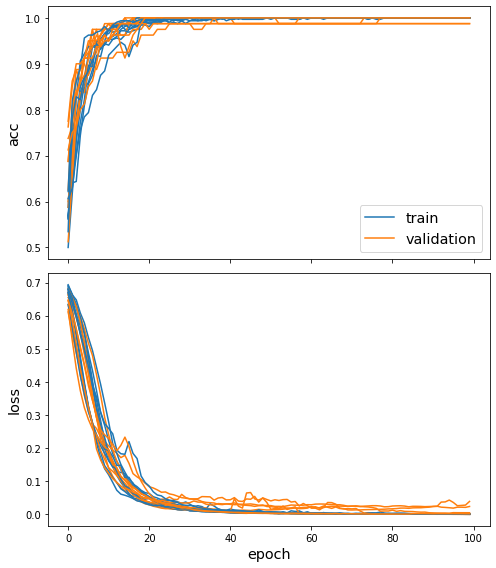

In [ ]:
fig = sg.utils.plot_history(dgcnn_history['r1node'], return_figure=True)
fig.savefig('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/history_r1node.png')

## n-node importance (greedy search)

In [ ]:
runid = 'rnnode'
dgcnn_history = {}
K = 10 # number of DGCNN runs
N_EPOCH = 100 # number of epochs per run
sample_frac = 0.4 # fraction of graphs sampled per iter used to calculate importance
n = 20 # n-node importance is desired

In [ ]:
W_mbc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbc.csv', dtype={'graph_ind': 'int'})
W_mbcrc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbcrc.csv', dtype={'graph_ind': 'int'})

nodes = read_graphs2(W_mbc)[0].nodes() # node labels
feature_array = np.identity(len(nodes)) # feature array taken as identity matrix
node_features = sg.IndexedArray(feature_array, index=list(nodes))
cg = read_graphs2(W_mbc, node_features)
crcg = read_graphs2(W_mbcrc, node_features)
graphs = cg + crcg
graph_labels = pd.Series(len(cg) * ['C'] + len(crcg) * ['CRC'])
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

ngraphs = max(W_mbcrc['graph_ind'])
history = []
node_lor = []
for _ in range(K):
  model, hist = train_dgcnn(graphs, graph_labels, n_epochs=N_EPOCH)
  history.append(hist)

  # Sample a subset of graphs from W_mbcrc
  rind = 1 + np.random.choice(ngraphs, size=round(ngraphs*sample_frac), replace=False)
  W_mbcrc2 = W_mbcrc[W_mbcrc['graph_ind'].isin(rind)]
  imp_calculator = ImportanceDGCNN(W_mbcrc2, node_features, model)
  nn_imp = imp_calculator.nnode_imp(n) # n-node imp

  # Each model can result in different selected k-nodes (k=1,...,n), so will not
  # attempt to combine the log-odds ratio arrays
  node_lor.append(nn_imp) 

dgcnn_history[runid] = history
save_imp_res(node_lor, runid=runid)

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Test Set Metrics: 
	loss: 0.0550
	acc: 0.9750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Test Set Metrics: 
	loss: 0.0339
	acc: 0.9875


# Test script

In [ ]:
runid = 'MBQC_Baseline'
W_mbc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/' + runid + '/W_mbc.csv', dtype={'graph_ind': 'int'})
W_mbcrc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/' + runid + '/W_mbcrc.csv', dtype={'graph_ind': 'int'})
nodes = read_graphs2(W_mbc)[0].nodes() # node labels
feature_array = np.identity(len(nodes)) # feature array taken as identity matrix
node_features = sg.IndexedArray(feature_array, index=list(nodes))
cg = read_graphs2(W_mbc, node_features)
crcg = read_graphs2(W_mbcrc, node_features)
graphs = cg + crcg
graph_labels = pd.Series(len(cg) * ['C'] + len(crcg) * ['CRC'])
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

ngraphs = max(W_mbcrc['graph_ind'])

In [ ]:
model, hist = train_dgcnn(graphs, graph_labels, n_epochs=100)

Instructions for updating:
Use fn_output_signature instead


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Test Set Metrics: 
	loss: 0.0030
	acc: 1.0000


In [ ]:
imp_calculator = ImportanceDGCNN(W_mbcrc, node_features, model)

In [ ]:
stats, LR = imp_calculator.node_pair_imp()

0: NODES (('g__Bifidobacterium', 'g__Eggerthella')) DONE.
100: NODES (('g__Streptococcus', 'g__Blautia')) DONE.
200: NODES (('g__Clostridium', 'f__Lachnospiraceae')) DONE.
300: NODES (('g__Bifidobacterium', 'f__Ruminococcaceae')) DONE.
400: NODES (('g__Faecalibacterium', 'g__Veillonella')) DONE.
500: NODES (('g__Parabacteroides', 'g__[Eubacterium]')) DONE.
600: NODES (('g__Prevotella', 'g__Bilophila')) DONE.
700: NODES (('g__Sutterella', 'g__Haemophilus')) DONE.


In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

def plot_lor(imp_res, K, by_med=True):
  """ Plot log odds ratio for some edges or nodes, determined automatically from input
  Args:
      imp_res: result from either edge_imp or node_imp instance method, 
               a tuple with two components: a summary dataframe and
               the LR matrix with shape #graphs-by-#nodes/edges
      K:  top K edges/nodes that when removed resulted in max change in log odds 
  """
  df, LR = imp_res
  lor = df['lor_med'] if by_med else df['lor_mean']
  max_ind = np.argsort(-abs(lor))[:K] # indices of K edges/nodes

  df_long = pd.concat([pd.DataFrame({'node1': df.iloc[i].at['node1'], 
                                  'node2': df.iloc[i].at['node2'], 
                                  'lor': LR[:, i]}) for i in max_ind], 
                    ignore_index=True)
  df_long = df_long.assign(node_pair=df_long['node1'] + ',' + df_long['node2'])
  ax = sns.boxplot(x="node_pair", y="lor", data=df_long)

  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

  
                                      

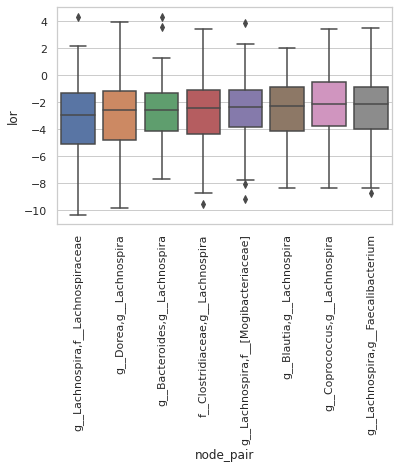

In [ ]:
plot_lor((stats, LR), K = 8)

## n-node

In [ ]:
runid = 'rnnode'
W_mbc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbc.csv', dtype={'graph_ind': 'int'})
W_mbcrc = pd.read_csv('/content/drive/MyDrive/MB_banocc_dgcnn/MBQC_Baseline/W_mbcrc.csv', dtype={'graph_ind': 'int'})
nodes = read_graphs2(W_mbc)[0].nodes() # node labels
feature_array = np.identity(len(nodes)) # feature array taken as identity matrix
node_features = sg.IndexedArray(feature_array, index=list(nodes))
cg = read_graphs2(W_mbc, node_features)
crcg = read_graphs2(W_mbcrc, node_features)
graphs = cg + crcg
graph_labels = pd.Series(len(cg) * ['C'] + len(crcg) * ['CRC'])
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

ngraphs = max(W_mbcrc['graph_ind'])

In [ ]:
model, hist = train_dgcnn(graphs, graph_labels, n_epochs=100)

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Test Set Metrics: 
	loss: 0.0187
	acc: 0.9875


In [ ]:
rind = 1 + np.random.choice(ngraphs, size=round(ngraphs*0.4), replace=False)
W_mbcrc2 = W_mbcrc[W_mbcrc['graph_ind'].isin(rind)]

In [ ]:
imp_calculator = ImportanceDGCNN(W_mbcrc2, node_features, model)

In [ ]:
out = imp_calculator.nnode_imp(4, ['g__Bifidobacterium', 'f__Lachnospiraceae'])